In [1]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
from imgaug import augmenters as iaa

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Global Variables

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
IMAGE_SIZE = 224

In [5]:
aug = iaa.Sequential([
                    iaa.Affine(translate_px={'x': (-10, 10)}, mode='constant'),
                    iaa.LinearContrast(0.5),
                    iaa.Affine(rotate=(-30, 30))
                    ], random_order=True)

# Dataset

In [6]:
def getFile_from_drive(file_id, name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(name)

In [7]:
getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

In [8]:
!unzip -qq fairface-img-margin025-trainval.zip

In [9]:
train_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
train_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [10]:
class GenderAgeDataset(Dataset):
    def __init__(self, df, aug=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.aug = aug
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, ix):
        person = self.df.iloc[ix]
        
        file = person.file
        gender = int(person.gender == "Female") # Female is 1 and Male is 0
        age = person.age

        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        return img, age, gender

    def preprocess_image(self, img):
        if self.aug:
            img = self.aug.augment_images(images=img)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img / 255.)
        return img[None]
      
    def collate_fn(self, batch):
        images, ages, genders = [], [], []
        for img, age, gender in batch:
            img = self.preprocess_image(img)
            images.append(img)

            ages.append(float(age / 80))
            genders.append(float(gender))
        
        images = torch.cat(images).to(device)
        ages = torch.tensor(ages).to(device).float()
        genders = torch.tensor(genders).to(device).float()

        return images, ages, genders

In [11]:
# create datasets
train = GenderAgeDataset(train_df)
val = GenderAgeDataset(val_df)

# Specify the data loaders
train_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True, 
                      collate_fn=train.collate_fn)
test_dl = DataLoader(val, batch_size=32, shuffle=True, 
                     collate_fn=val.collate_fn)

In [12]:
# verify data loader
img, age, gender = next(iter(train_dl))
img.shape, age.shape, gender.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]), torch.Size([32]))

# Functions

In [13]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    model.avgpool = nn.Sequential(
                                    nn.Conv2d(512, 512, kernel_size=3),
                                    nn.MaxPool2d(2),
                                    nn.ReLU(),
                                    nn.Flatten()
                                 )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                                      nn.Linear(2048, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(512, 128),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(128, 64),
                                      nn.ReLU(),
                                )
            
            self.age_classifier = nn.Sequential(
                                      nn.Linear(64, 1),
                                      nn.Sigmoid()
                                  )
            self.gender_classifier = nn.Sequential(
                                      nn.Linear(64, 1),
                                      nn.Sigmoid()
                                  )
            
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
    
    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model.to(device), loss_functions, optimizer

In [14]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    images, ages, genders = data

    pred_genders, pred_ages = model(images)
    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_genders.squeeze(), genders)
    age_loss = age_criterion(pred_ages.squeeze(), ages)

    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return total_loss

In [15]:
def validate_batch(data, model, criteria):
    model.eval()
    images, ages, genders = data

    with torch.no_grad():
        pred_genders, pred_ages = model(images)

    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_genders.squeeze(), genders)
    age_loss = age_criterion(pred_ages.squeeze(), ages)

    total_loss = gender_loss + age_loss

    pred_genders = (pred_genders > 0.5).squeeze()
    gender_acc = (pred_genders == genders).float().sum()
    age_mae = torch.abs(ages - pred_ages).float().sum()
    
    return total_loss, gender_acc, age_mae

In [16]:
model, criteria, optimizer = get_model()

val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 5
best_test_loss = float('inf')

In [17]:
train_dl_size, test_dl_size, test_image_numbers = len(train_dl), len(test_dl),\
                                                  len(test_dl) * 32
for epoch in range(n_epochs):
    print(f"Epoch: {(epoch + 1):03d}")
    
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc= 0, 0

    for data in train_dl:
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item()

    for data in test_dl:
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
    
    val_age_mae /= test_image_numbers
    val_gender_acc /= test_image_numbers
    epoch_train_loss /= train_dl_size
    epoch_test_loss /= test_dl_size

    best_test_loss = min(best_test_loss, epoch_test_loss)
    info = f"Train loss: {epoch_train_loss:.3f}\n"\
           f"Test loss: {epoch_test_loss:.3f}\n"\
           f"Best test loss: {best_test_loss:.4f}\n"\
           f"Gender Accuracy: {val_gender_acc * 100:.2f}%\n"\
           f"Age MAE: {val_age_mae:.2f}\n"\
            "---------------------------\n"
    print(info)

    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

Epoch: 001
Train loss: 0.551
Test loss: 0.461
Best test loss: 0.4614
Gender Accuracy: 83.32%
Age MAE: 6.05
---------------------------

Epoch: 002
Train loss: 0.400
Test loss: 0.447
Best test loss: 0.4467
Gender Accuracy: 84.48%
Age MAE: 6.27
---------------------------

Epoch: 003
Train loss: 0.282
Test loss: 0.502
Best test loss: 0.4467
Gender Accuracy: 83.87%
Age MAE: 6.40
---------------------------

Epoch: 004
Train loss: 0.196
Test loss: 0.622
Best test loss: 0.4467
Gender Accuracy: 83.05%
Age MAE: 6.33
---------------------------

Epoch: 005
Train loss: 0.156
Test loss: 0.720
Best test loss: 0.4467
Gender Accuracy: 83.45%
Age MAE: 6.34
---------------------------



In [18]:
val_gender_accuracies = [accuracy.item() for accuracy in val_gender_accuracies]
val_age_maes = [mae.item() for mae in val_age_maes]

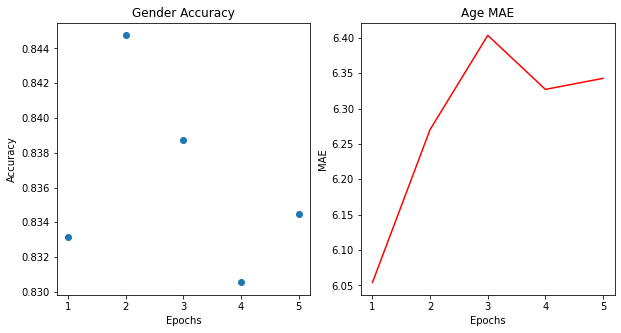

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

epochs = [i for i in range(1, 6)]

# Gender Accuracy
ax[0].scatter(x=epochs,
            y=val_gender_accuracies)

ax[0].set(title= "Gender Accuracy",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Age MAE
ax[1].plot(epochs, val_age_maes, 'r')

ax[1].set(title= "Age MAE",
        ylabel= "MAE",
        xlabel= "Epochs");

# Make a prediction of age and gender on a random test image

In [28]:
img = cv2.imread('drive/MyDrive/Me.jpg')
img = train.preprocess_image(img).to(device)

gender, age = model(img)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

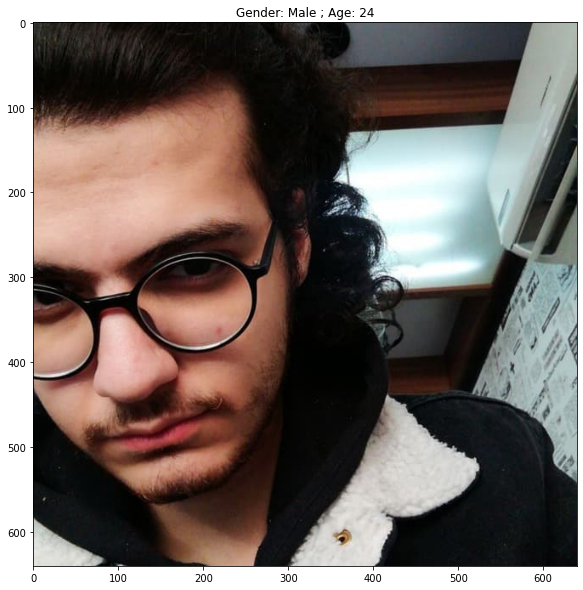

In [29]:
predicted_gender = "Male" if pred_gender.item() < 0.5 else "Female"
predicted_age = int(pred_age.item() * 80)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(cv2.cvtColor(cv2.imread('drive/MyDrive/Me.jpg'),
                       cv2.COLOR_BGR2RGB))
ax.set(title= f"Gender: {predicted_gender} ; Age: {predicted_age}");

Two years older than what I expected.

In [30]:
img = cv2.imread('drive/MyDrive/Ali.jpg')
img = train.preprocess_image(img).to(device)

gender, age = model(img)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

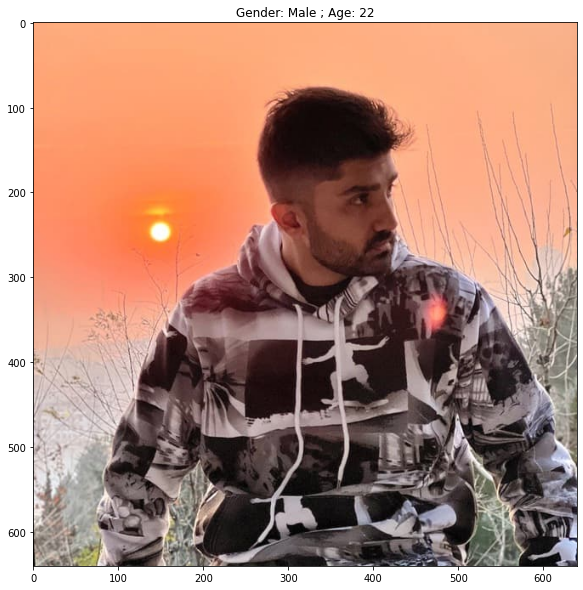

In [31]:
predicted_gender = "Male" if pred_gender.item() < 0.5 else "Female"
predicted_age = int(pred_age.item() * 80)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(cv2.cvtColor(cv2.imread('drive/MyDrive/Ali.jpg'),
                       cv2.COLOR_BGR2RGB))
ax.set(title= f"Gender: {predicted_gender} ; Age: {predicted_age}");

One year older than what he is